# Exploratory Data Analysis: NASA CMAPSS Aircraft Engine Dataset

### **Author: Nicholi Caron** (Interview Preparation)

## Overview
This notebook analyzes the NASA Commercial Modular Aero-Propulsion System Simulation (CMAPSS) dataset,
which contains run-to-failure simulations for aircraft turbofan engines. The dataset is commonly
used for developing predictive maintenance algorithms and remaining useful life (RUL) predictions.

## Dataset Background
The CMAPSS dataset simulates degradation in aircraft engines operating under different flight
conditions. Each engine starts with different degrees of initial wear and manufacturing variation,
then develops a fault that grows over time until system failure.

Key dataset characteristics:
- Multiple operating conditions (altitude, Mach number, throttle setting)
- 21 sensor measurements per cycle
- Each engine runs until failure in the training set
- Test set engines terminate before failure

## Analysis Goals
1. Understand engine degradation patterns
2. Identify key sensor measurements that correlate with remaining useful life
3. Explore relationships between different sensor readings
4. Prepare data for predictive maintenance modeling

## Dataset Files
We'll focus on FD001 dataset, which represents a single operating condition with a single failure mode.
(Link to Dataset: https://www.kaggle.com/datasets/behrad3d/nasa-cmaps/data)

In [5]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn import preprocessing
from tabulate import tabulate  # For displaying nicely formatted tables

# Set consistent styling for visualizations
plt.style.use('seaborn-v0_8-pastel')
sns.set_context("notebook", font_scale=1.2)

# Setting seed for reproducibility
np.random.seed(42)

In [6]:
# List of sensor names for reference
# These represent different measurements from the engine
sensors = [
    'T2',   # Total temperature at fan inlet
    'T24',  # Total temperature at LPC outlet
    'T30',  # Total temperature at HPC outlet
    'T50',  # Total temperature at LPT outlet
    'P2',   # Pressure at fan inlet
    'P15',  # Total pressure in bypass-duct
    'P30',  # Total pressure at HPC outlet
    'Nf',   # Physical fan speed
    'Nc',   # Physical core speed
    'epr',  # Engine pressure ratio (P50/P2)
    'Ps30', # Static pressure at HPC outlet
    'phi',  # Ratio of fuel flow to Ps30
    'NRf',  # Corrected fan speed
    'NRc',  # Corrected core speed
    'BPR',  # Bypass Ratio
    'farB', # Burner fuel-air ratio
    'htBleed', # Bleed Enthalpy
    'Nf_dmd',  # Demanded fan speed
    'PCNfR_dmd', # Demanded corrected fan speed
    'W31',  # HPT coolant bleed
    'W32'   # LPT coolant bleed
]

## SECTION 1: DATA LOADING AND PREPARATION

In [7]:
# Set the file names for the first dataset (FD001)
train_file = 'train_FD001.txt'
test_file = 'test_FD001.txt'
rul_file = 'RUL_FD001.txt'

# NOTE: In a real environment, you would use your local dataset path
# For this analysis, we'll assume the data files are in the same folder as this file
dataset_path = './' # Adjust as needed

# Function to load CMAPSS data files
def load_cmapss_data(dataset_path, file_name):
    """
    Load CMAPSS dataset files with proper column names.

    Parameters:
    -----------
    dataset_path : str
        Directory where the dataset files are located
    file_name : str
        Name of the file to load

    Returns:
    --------
    pandas.DataFrame
        Loaded dataset with appropriate column names
    """
    file_path = os.path.join(dataset_path, file_name)

    # CMAPSS files are space-delimited without headers
    data = pd.read_csv(file_path, delimiter='\s+', header=None)

    # Define column names for better readability
    columns = [
        'engine_id', 'cycle', 'setting_1', 'setting_2', 'setting_3',
        'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf',
        'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR',
        'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32'
    ]

    data.columns = columns
    return data

# Load the datasets
try:
    train_data = load_cmapss_data(dataset_path, train_file)
    test_data = load_cmapss_data(dataset_path, test_file)

    # RUL data has only one column with no header
    rul_path = os.path.join(dataset_path, rul_file)
    rul_data = pd.read_csv(rul_path, delimiter='\s+', header=None)

    print("✅ Successfully loaded CMAPSS datasets")

except FileNotFoundError:
    print("""
    ⚠️ Dataset files not found!

    This script is designed to work with the NASA CMAPSS Turbofan Engine Dataset.
    The dataset can be found here: https://www.kaggle.com/datasets/behrad3d/nasa-cmaps/data
    """)

✅ Successfully loaded CMAPSS datasets


## SECTION 2: CALCULATING REMAINING USEFUL LIFE

In predictive maintenance, Remaining Useful Life (RUL) is the key metric we want to predict.
RUL represents how many more cycles an engine can operate before failure.

For the training data:
- RUL = (max_cycle - current_cycle) for each engine
- This represents a countdown to failure

For the test data:
- RUL values are provided separately in the RUL file
- These represent the true RUL at the last cycle recorded in the test set

In [8]:
def calculate_rul(train_data, test_data, rul_data):
    """
    Calculate Remaining Useful Life (RUL) for both training and test datasets.

    For training data: RUL is calculated as (max_cycle - current_cycle)
    For test data: RUL is calculated based on the provided RUL values at the end of each sequence

    Parameters:
    -----------
    train_data : pandas.DataFrame
        Training dataset with engine data
    test_data : pandas.DataFrame
        Test dataset with engine data
    rul_data : pandas.DataFrame
        RUL values for the test dataset engines

    Returns:
    --------
    tuple (pandas.DataFrame, pandas.DataFrame)
        Training and test datasets with added RUL values
    """

    # Add RUL to training data
    def add_rul_to_engine(group):
        """Calculate RUL for each row in an engine group"""
        max_cycle = group['cycle'].max()
        group['RUL'] = max_cycle - group['cycle']
        return group

    # Group by engine ID and apply the RUL calculation
    train_data_with_rul = train_data.groupby('engine_id').apply(add_rul_to_engine)

    # Calculate RUL for the test data
    unique_engines = test_data["engine_id"].unique()
    rul_list = []

    for engine_idx, engine_id in enumerate(unique_engines):
        # Get all cycles for this engine
        engine_cycles = np.array(test_data[test_data['engine_id'] == engine_id]['cycle'])
        cycles_count = len(engine_cycles)

        # Get the true RUL value for this engine (provided in the RUL file)
        true_rul = rul_data.iloc[engine_idx][0]

        # Calculate RUL for each cycle
        # The RUL decreases with each cycle, starting from (last_cycle_count - 1 + true_rul)
        engine_ruls = list(cycles_count - engine_cycles + true_rul)
        rul_list.extend(engine_ruls)

    # Add the RUL values to the test data
    test_data_with_rul = test_data.copy()
    test_data_with_rul['RUL'] = rul_list

    return train_data_with_rul, test_data_with_rul

# Calculate RUL for both datasets
train_data_with_rul, test_data_with_rul = calculate_rul(train_data, test_data, rul_data)

# Display sample data from each dataset
print("\n📊 Sample Data Preview")
print("\nTraining Data (with RUL values):")
print(tabulate(train_data_with_rul.head(), headers="keys", tablefmt="fancy_grid"))

print("\nTest Data (with RUL values):")
print(tabulate(test_data_with_rul.head(), headers="keys", tablefmt="fancy_grid"))


📊 Sample Data Preview

Training Data (with RUL values):
╒════════╤═════════════╤═════════╤═════════════╤═════════════╤═════════════╤════════╤════════╤═════════╤═════════╤═══════╤═══════╤════════╤═════════╤═════════╤═══════╤════════╤════════╤═════════╤═════════╤════════╤════════╤═══════════╤══════════╤═════════════╤═══════╤═════════╤═══════╕
│        │   engine_id │   cycle │   setting_1 │   setting_2 │   setting_3 │     T2 │    T24 │     T30 │     T50 │    P2 │   P15 │    P30 │      Nf │      Nc │   epr │   Ps30 │    phi │     NRf │     NRc │    BPR │   farB │   htBleed │   Nf_dmd │   PCNfR_dmd │   W31 │     W32 │   RUL │
╞════════╪═════════════╪═════════╪═════════════╪═════════════╪═════════════╪════════╪════════╪═════════╪═════════╪═══════╪═══════╪════════╪═════════╪═════════╪═══════╪════════╪════════╪═════════╪═════════╪════════╪════════╪═══════════╪══════════╪═════════════╪═══════╪═════════╪═══════╡
│ (1, 0) │           1 │       1 │     -0.0007 │     -0.0004 │         100 │ 518.6

<ipython-input-8-789249904bc5>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_data_with_rul = train_data.groupby('engine_id').apply(add_rul_to_engine)


## SECTION 3: EXPLORATORY DATA ANALYSIS
Now we'll explore the data to understand its characteristics and identify patterns that might be useful for predicting RUL.

In [9]:
class DatasetInspector:
    """
    A utility class to perform comprehensive data inspection and generate reports.

    This class helps identify key dataset characteristics like:
    - Shape (rows and columns)
    - Data types
    - Missing values
    - Duplicates
    - Basic statistics
    """

    def __init__(self, data: pd.DataFrame, dataset_name="Dataset"):
        """Initialize with a pandas DataFrame"""
        if not isinstance(data, pd.DataFrame):
            raise ValueError('Input data must be a pandas DataFrame')
        self.data = data
        self.name = dataset_name

    def inspect(self):
        """Generate a comprehensive inspection report of the dataset"""
        print(f"\n📋 {self.name} Inspection Report\n")

        # Shape
        print("📏 Shape of Dataset:")
        print(f"  • Number of Rows: {self.data.shape[0]}")
        print(f"  • Number of Columns: {self.data.shape[1]}\n")

        # Column Data Types
        print("🔤 Column Data Types:")
        print(self.data.dtypes, '\n')

        # Missing Values
        missing_values = self.data.isnull().sum()
        print("🔍 Missing Values:")
        if missing_values.sum() > 0:
            print(missing_values[missing_values > 0], '\n')
        else:
            print("  • No missing values found\n")

        # Duplicates
        duplicate_count = self.data.duplicated().sum()
        print("🔄 Duplicate Rows:")
        print(f"  • Number of duplicate rows: {duplicate_count}\n")

        # Basic Statistics
        print("📊 Basic Statistics:")
        print(self.data.describe(), '\n')

        # Top 5 Records
        print("⬆️ Top 5 Records:")
        print(self.data.head(), '\n')

        # Bottom 5 Records
        print("⬇️ Bottom 5 Records:")
        print(self.data.tail(), '\n')

In [10]:
# Inspect the training dataset
print("\n" + "="*80)
print("DATASET INSPECTION")
print("="*80)
dataset_inspector = DatasetInspector(train_data_with_rul, "Training Dataset (FD001)")
dataset_inspector.inspect()


DATASET INSPECTION

📋 Training Dataset (FD001) Inspection Report

📏 Shape of Dataset:
  • Number of Rows: 20631
  • Number of Columns: 27

🔤 Column Data Types:
engine_id      int64
cycle          int64
setting_1    float64
setting_2    float64
setting_3    float64
T2           float64
T24          float64
T30          float64
T50          float64
P2           float64
P15          float64
P30          float64
Nf           float64
Nc           float64
epr          float64
Ps30         float64
phi          float64
NRf          float64
NRc          float64
BPR          float64
farB         float64
htBleed        int64
Nf_dmd         int64
PCNfR_dmd    float64
W31          float64
W32          float64
RUL            int64
dtype: object 

🔍 Missing Values:
  • No missing values found

🔄 Duplicate Rows:
  • Number of duplicate rows: 0

📊 Basic Statistics:
          engine_id         cycle     setting_1     setting_2  setting_3  \
count  20631.000000  20631.000000  20631.000000  20631.000000 

### SECTION 4: OPERATIONAL SETTINGS ANALYSIS

Before analyzing sensor readings, let's understand the operational settings.
These represent the conditions under which the engines were operating.

For FD001:
- setting_1: altitude
- setting_2: Mach number
- setting_3: throttle resolver angle (TRA)

Understanding these is important because sensor readings may vary based on operational conditions.


OPERATIONAL SETTINGS ANALYSIS

📈 Distribution of Operating Conditions Across Engines
This analysis helps us understand if all engines operated in similar conditions.


<ipython-input-11-8a766f38f238>:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
<ipython-input-11-8a766f38f238>:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
<ipython-input-11-8a766f38f238>:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
<ipython-input-11-8a766f38f238>:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
<ipython-input-11-8a766f38f238>:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
<ipython-input-11-8a766f38f238>:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot

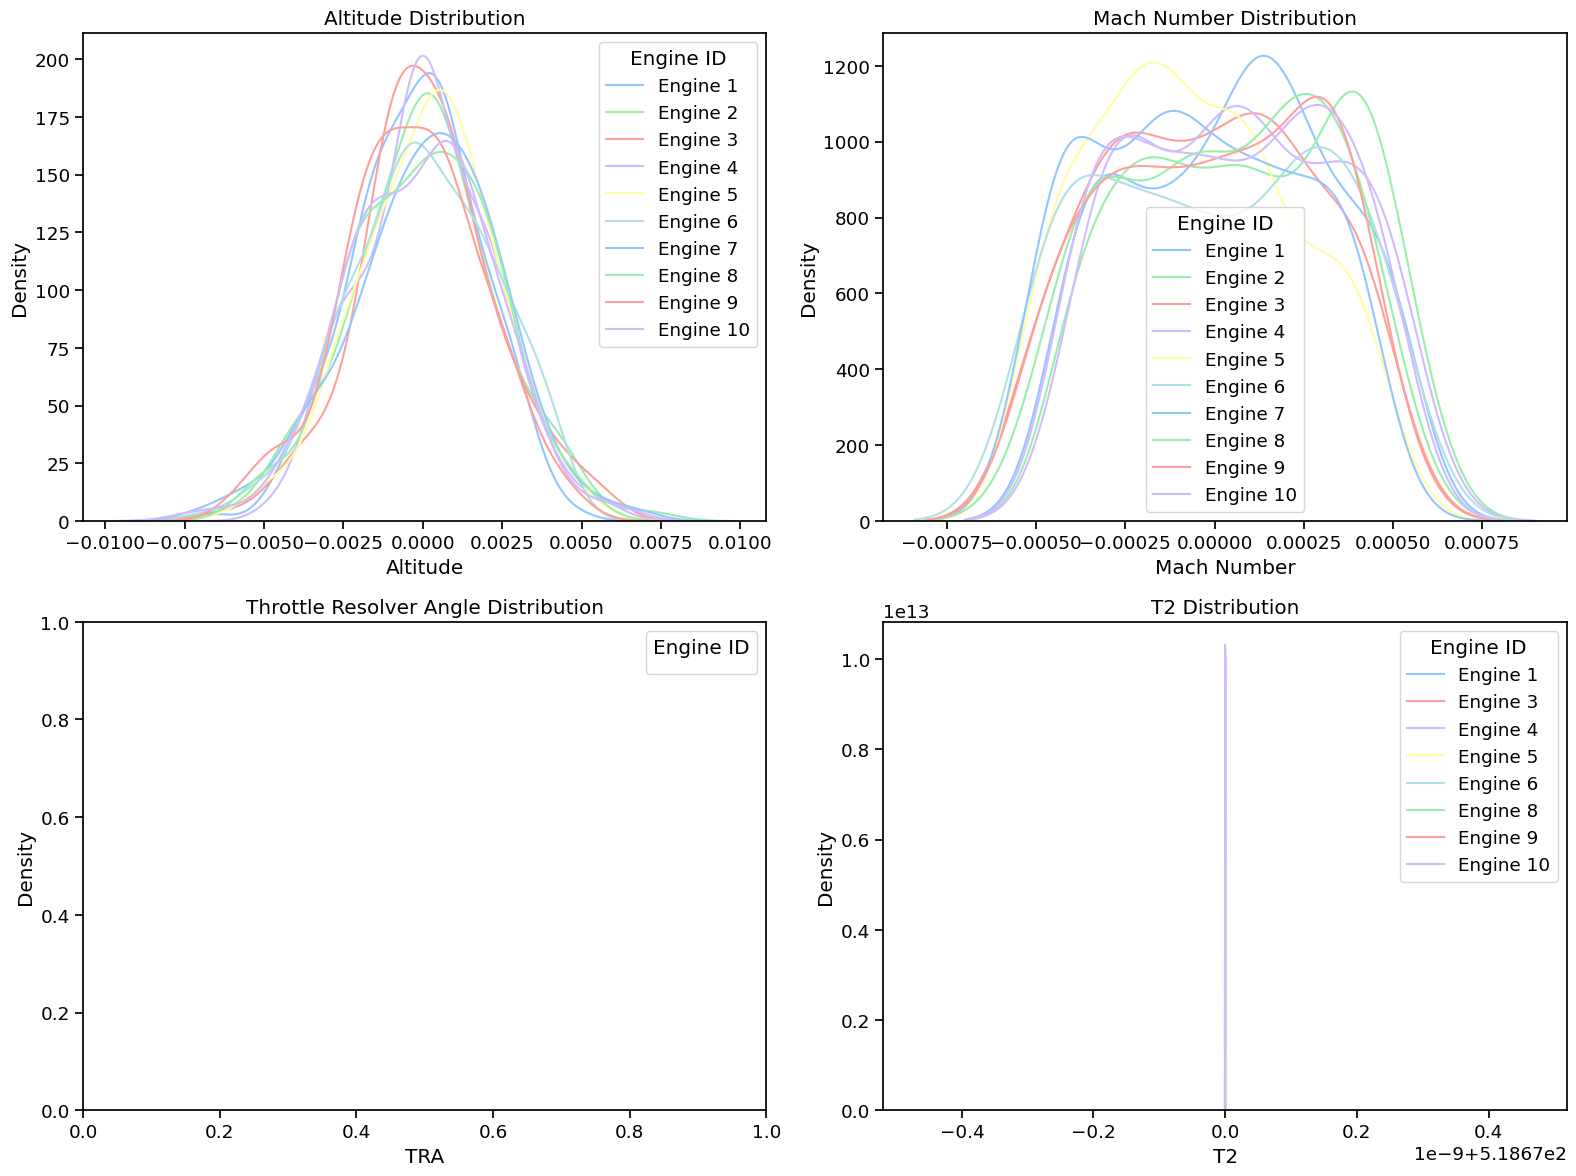

In [11]:
print("\n" + "="*80)
print("OPERATIONAL SETTINGS ANALYSIS")
print("="*80)
print("\n📈 Distribution of Operating Conditions Across Engines")
print("This analysis helps us understand if all engines operated in similar conditions.")

# Select a subset of engines for visualization
selected_engines = range(1, 11)  # Engines 1 through 10
engines_subset = train_data_with_rul[train_data_with_rul['engine_id'].isin(selected_engines)]

# Analyze operating conditions (settings)
operational_settings = ['setting_1', 'setting_2', 'setting_3', 'T2']  # T2 included as an example sensor

# Plotting distributions for each setting across engines
plt.figure(figsize=(16, 12))
for i, setting in enumerate(operational_settings):
    plt.subplot(2, 2, i+1)
    for engine_id in selected_engines:
        sns.kdeplot(
            data=engines_subset[engines_subset['engine_id'] == engine_id],
            x=setting,
            label=f'Engine {engine_id}'
        )

    # Add descriptive labels
    if setting == 'setting_1':
        title = 'Altitude Distribution'
        xlabel = 'Altitude'
    elif setting == 'setting_2':
        title = 'Mach Number Distribution'
        xlabel = 'Mach Number'
    elif setting == 'setting_3':
        title = 'Throttle Resolver Angle Distribution'
        xlabel = 'TRA'
    else:
        title = f'{setting} Distribution'
        xlabel = setting

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.legend(title='Engine ID')

plt.tight_layout()
plt.savefig('operational_settings.png')
plt.show()

🔑 Key Insights:
- Similar operational condition distributions across engines suggest standardized test conditions
- Understanding these distributions helps identify if certain operational ranges are more likely to lead to failure
- Similar distributions allow us to compare engine performance without adjusting for different conditions

### SECTION 5: SENSOR READINGS ANALYSIS
Now let's analyze the sensor readings across engines to identify degradation patterns.
We'll focus on sensors that show clear patterns associated with engine degradation.

By plotting sensor values against RUL, we can identify which sensors:
1. Show clear degradation trends
2. Have high correlation with RUL
3. Could be most useful for predicting failure

In [12]:
# Define key sensors showing degradation patterns (identified through analysis)
key_degradation_sensors = [
    'T24',  # Total temperature at LPC outlet
    'T30',  # Total temperature at HPC outlet
    'T50',  # Total temperature at LPT outlet
    'P30',  # Total pressure at HPC outlet
    'Nf',   # Physical fan speed
    'Nc',   # Physical core speed
    'Ps30', # Static pressure at HPC outlet
    'phi',  # Ratio of fuel flow to Ps30
    'NRf',  # Corrected fan speed
    'NRc',  # Corrected core speed
    'BPR',  # Bypass Ratio
    'htBleed', # Bleed Enthalpy
    'W31',  # HPT coolant bleed
    'W32'   # LPT coolant bleed
]

print("\n" + "="*80)
print("SENSOR READINGS ANALYSIS")
print("="*80)
print("\n📉 Sensor Readings vs. Remaining Useful Life")
print("These plots show how sensor readings change as engines approach failure.")


SENSOR READINGS ANALYSIS

📉 Sensor Readings vs. Remaining Useful Life
These plots show how sensor readings change as engines approach failure.


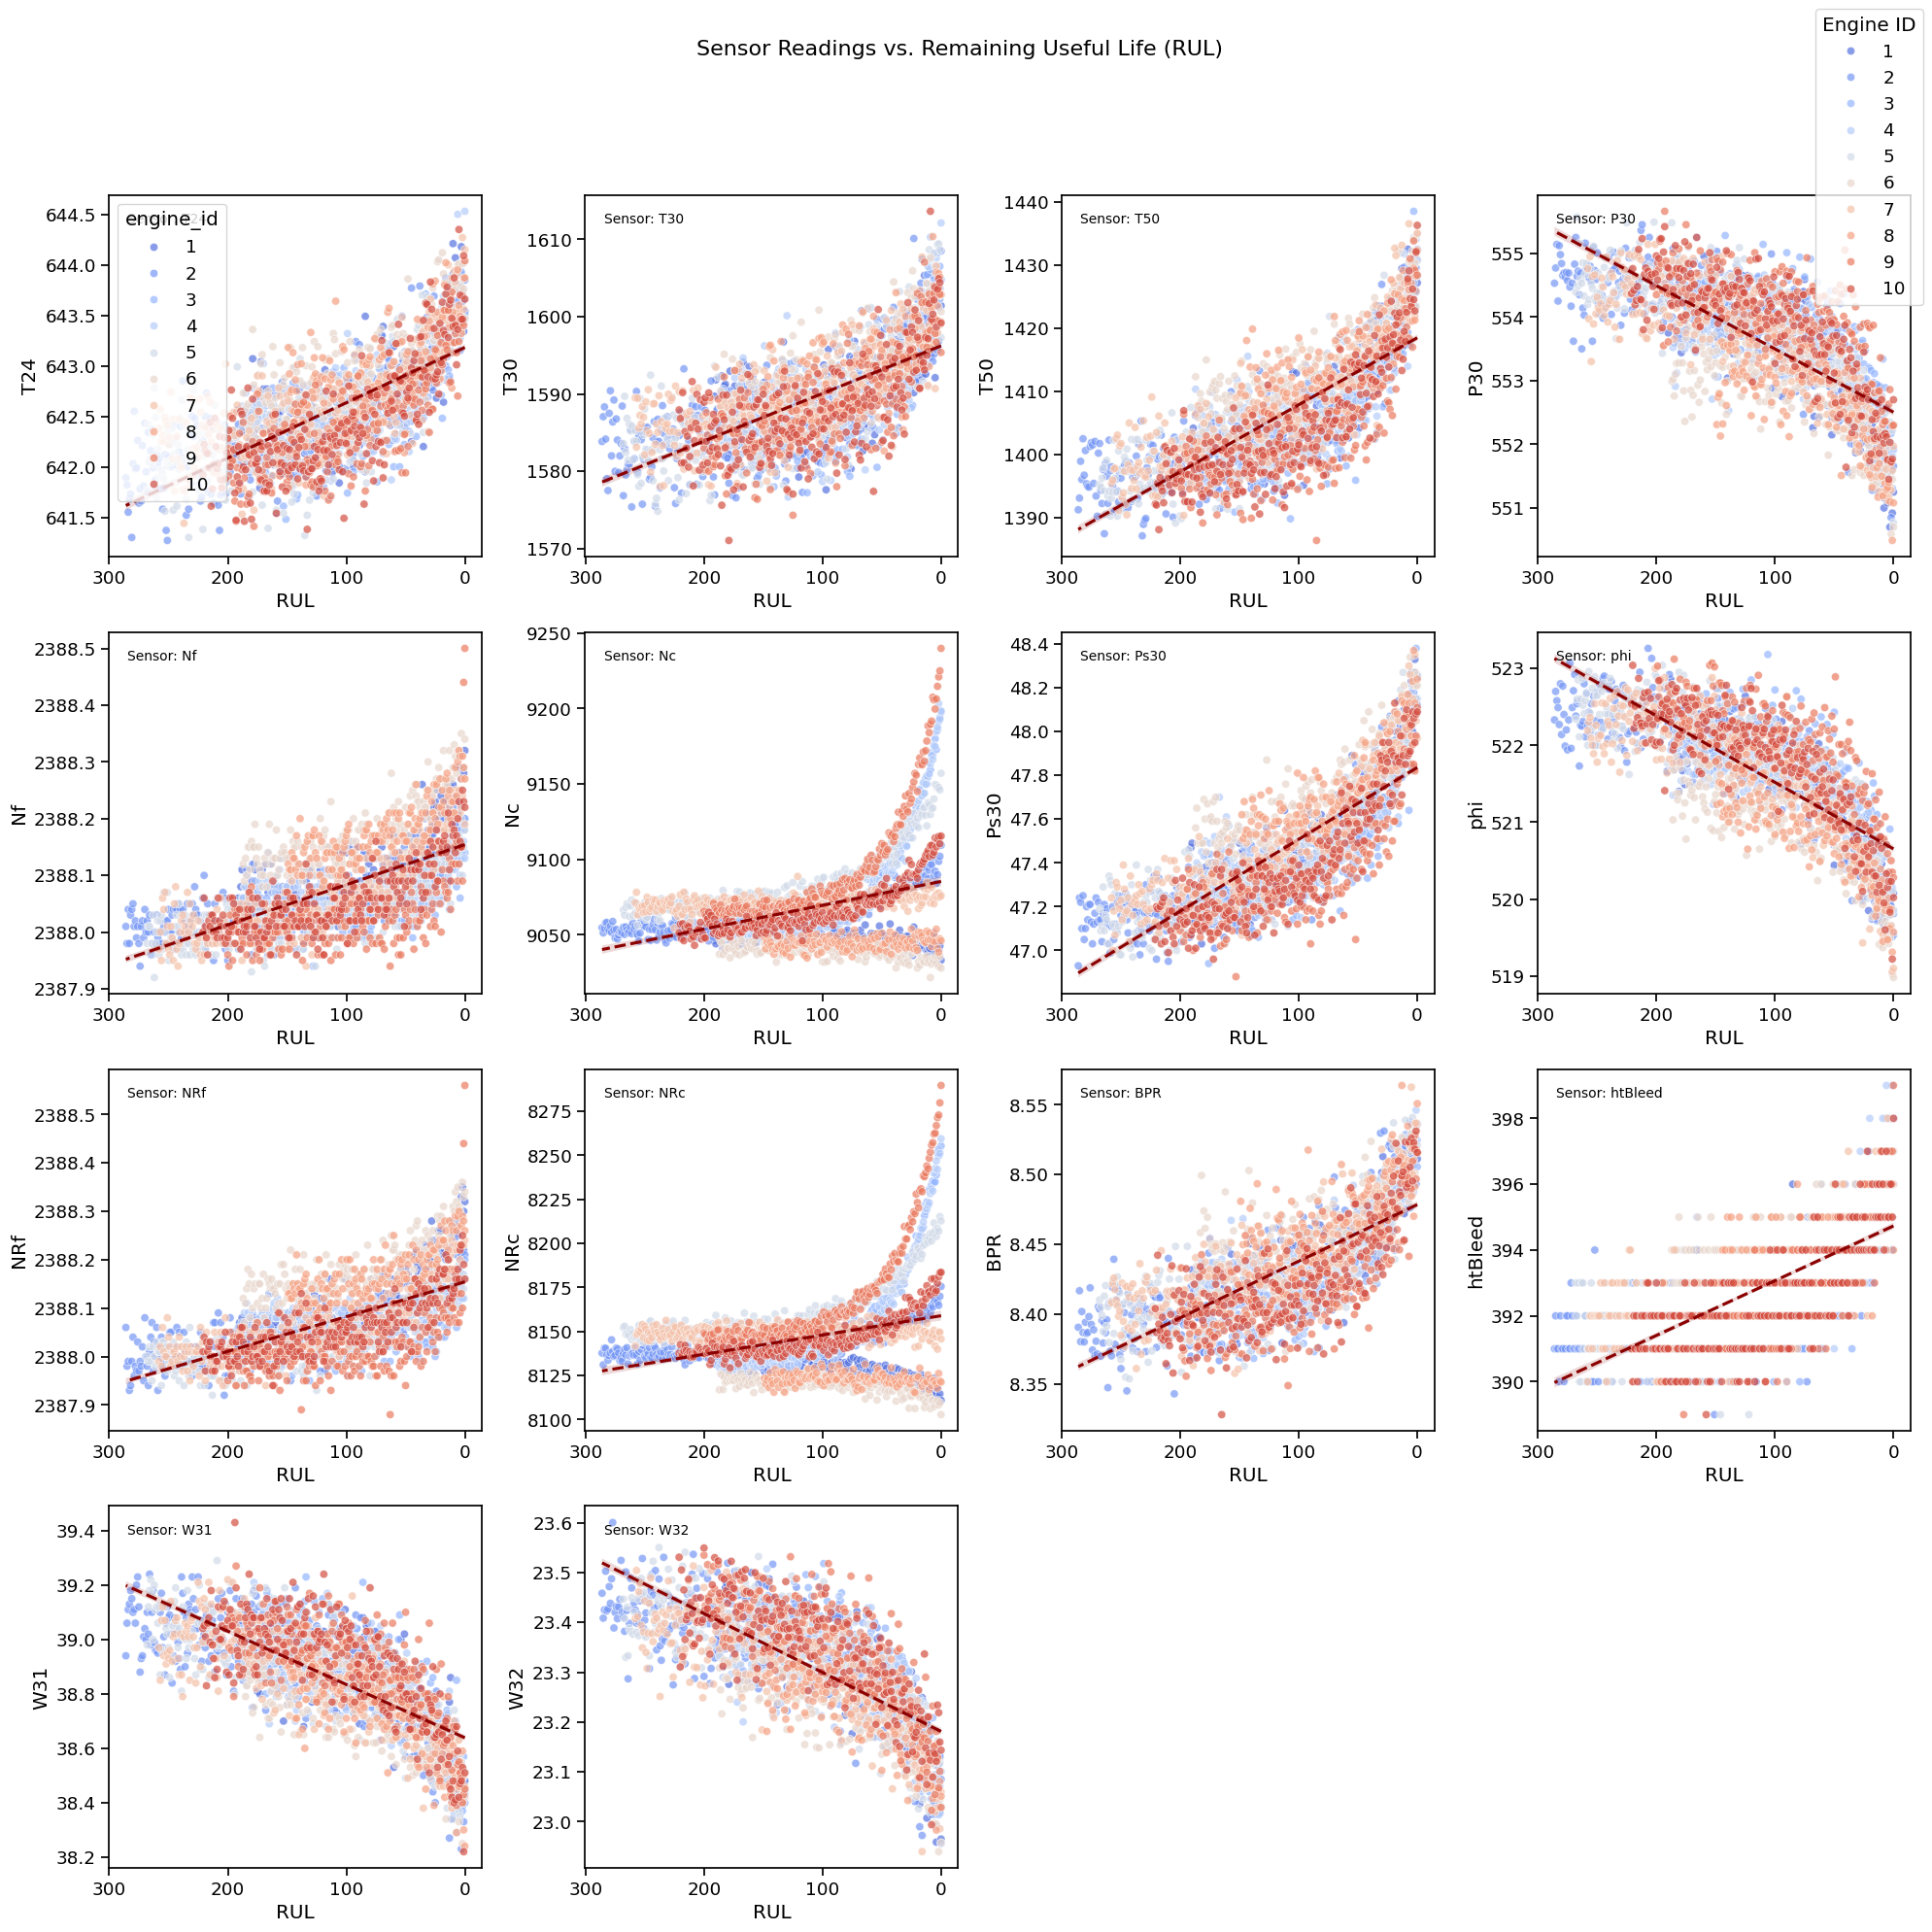

In [13]:
def scatter_indicators(dataframe, title, indicators, max_engines=10):
    """
    Create scatter plots showing sensor readings vs. RUL for multiple engines.

    Parameters:
    -----------
    dataframe : pandas.DataFrame
        DataFrame containing engine data with RUL
    title : str
        Title for the plot
    indicators : list
        List of sensor names to plot
    max_engines : int
        Maximum number of engines to include in the plot
    """
    # Count of indicators and engines
    indicators_count = len(indicators)

    # Limit the number of engines to plot (for clarity)
    unique_engines = dataframe['engine_id'].unique()[:max_engines]
    engines_count = len(unique_engines)

    # Filter data to include only selected engines
    plot_data = dataframe[dataframe['engine_id'].isin(unique_engines)]

    # Calculate grid dimensions - use 4 columns
    ncols = 4
    nrows = (indicators_count + ncols - 1) // ncols  # Ceiling division

    # Create subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))

    # Create and adjust title
    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(top=0.95)

    # Create color palette
    color_palette = sns.color_palette("coolwarm", engines_count)

    # Flatten axes for easier indexing
    axes = axes.flatten()

    # Iterate over indicators and create scatter plots
    for i, indicator in enumerate(indicators):
        # Plot scatter plot with RUL on x-axis
        sns.scatterplot(
            data=plot_data,
            ax=axes[i],
            x='RUL',
            y=indicator,
            hue='engine_id',
            palette=color_palette,
            alpha=0.7,
            legend=(i == 0)  # Only show legend in first plot
        )

        # Set axis labels
        axes[i].set_xlabel("Remaining Useful Life (cycles)")
        axes[i].set_ylabel(indicator)

        # Add a trend line to highlight the pattern
        sns.regplot(
            data=plot_data,
            ax=axes[i],
            x='RUL',
            y=indicator,
            scatter=False,
            color='darkred',
            line_kws={"linestyle":"--"}
        )

        # Invert x-axis so time flows left to right (from high RUL to low RUL)
        axes[i].invert_xaxis()

        # Add explanation text
        axes[i].text(
            0.05, 0.95,
            f"Sensor: {indicator}",
            transform=axes[i].transAxes,
            fontsize=10,
            verticalalignment='top'
        )

    # Delete remaining empty axes
    for j in range(indicators_count, len(axes)):
        fig.delaxes(axes[j])

    # Add legend in a separate area
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', title="Engine ID")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig('sensor_readings_vs_rul.png')
    plt.show()

# Plot sensor readings against RUL
scatter_indicators(
    train_data_with_rul,
    'Sensor Readings vs. Remaining Useful Life (RUL)',
    key_degradation_sensors
)

🔑 Key Insights:
- Sensors showing clear upward or downward trends as RUL decreases indicate degradation patterns
- Sensors with high variability but no clear trend may not be useful for predicting failure
- Different engines may show similar degradation patterns, indicating consistent failure modes
- These patterns can be used as features for predictive maintenance algorithms

💡 Real-world Translation:
- Just as car engine temperature rises before overheating, these aircraft engine sensors show
  measurable changes before failure occurs
- Changes in sensor readings represent early warning signs that maintenance teams can act on
- By monitoring these key sensors, airlines can schedule maintenance before failures occur

### SECTION 6: AGGREGATED SENSOR TRENDS

To better understand the overall trends, let's examine the aggregated behavior of each sensor
across all engines. This will help identify the general degradation patterns.

For each sensor, we'll plot:
- Mean value at each RUL point
- Min/max range to show variability

In [14]:
print("\n" + "="*80)
print("AGGREGATED SENSOR TRENDS")
print("="*80)
print("\n📊 Mean Sensor Values vs. Remaining Useful Life")
print("These plots show the average behavior of sensors as engines approach failure.")


AGGREGATED SENSOR TRENDS

📊 Mean Sensor Values vs. Remaining Useful Life
These plots show the average behavior of sensors as engines approach failure.


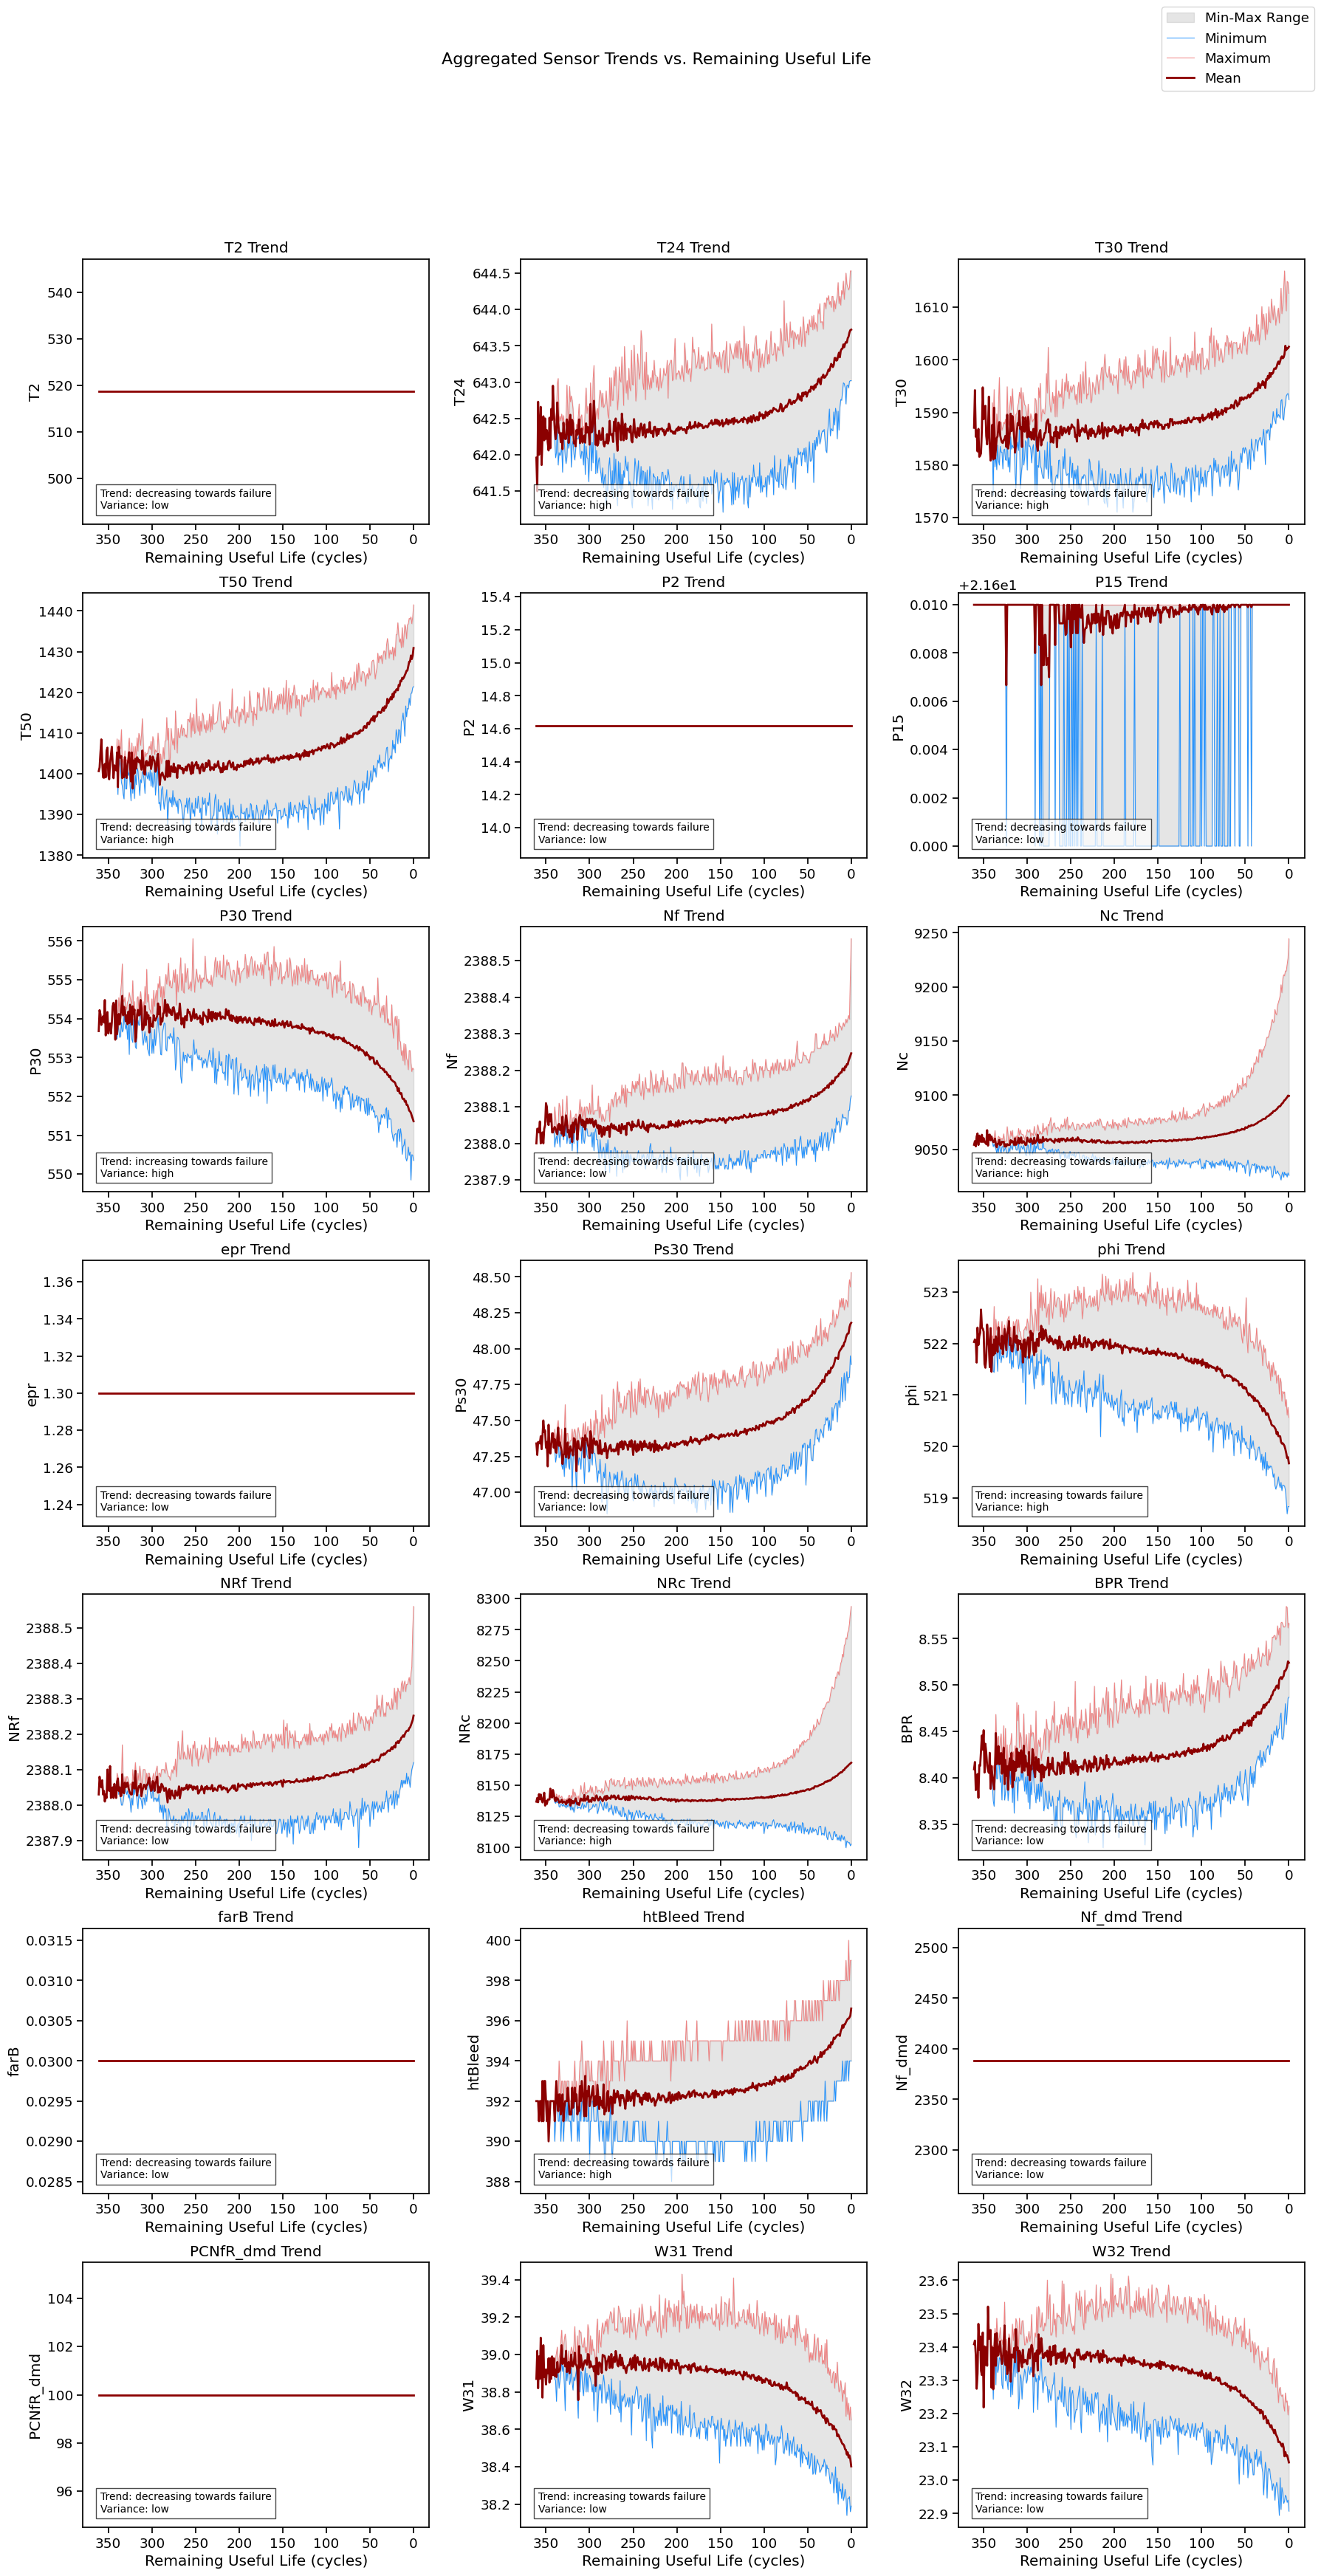

In [16]:
def line_indicators(dataframe, title, indicators):
    """
    Plot aggregated sensor readings (min, mean, max) against RUL.

    Parameters:
    -----------
    dataframe : pandas.DataFrame
        DataFrame containing engine data with RUL
    title : str
        Title for the plot
    indicators : list
        List of sensor names to plot
    """
    # Count of indicators
    indicators_count = len(indicators)

    # Aggregate dataframe by RUL (min, mean, max)
    grouped_data = dataframe.groupby(['RUL'])[indicators].agg(['min', 'mean', 'max'])

    # Calculate grid dimensions - use 3 columns
    ncols = 3
    nrows = (indicators_count + ncols - 1) // ncols  # Ceiling division

    # Create subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 5 * nrows))

    # Create and adjust title
    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(top=0.95)

    # Flatten axes for easier indexing
    axes = axes.flatten()

    # Iterate over indicators
    for i, indicator in enumerate(indicators):
        # Get current axis
        ax = axes[i]

        # Get aggregated data for this indicator
        indicator_data = grouped_data[indicator]

        # Plot filled area between min and max
        ax.fill_between(
            indicator_data.index,
            indicator_data['min'],
            indicator_data['max'],
            color='gray',
            alpha=0.2,
            label='Min-Max Range'
        )

        # Plot min line
        ax.plot(
            indicator_data.index,
            indicator_data['min'],
            color='dodgerblue',
            linewidth=0.7,
            label='Minimum'
        )

        # Plot max line
        ax.plot(
            indicator_data.index,
            indicator_data['max'],
            color='lightcoral',
            linewidth=0.7,
            label='Maximum'
        )

        # Plot mean line
        ax.plot(
            indicator_data.index,
            indicator_data['mean'],
            color='darkred',
            linewidth=2,
            label='Mean'
        )

        # Add labels
        ax.set_title(f"{indicator} Trend")
        ax.set_xlabel("Remaining Useful Life (cycles)")
        ax.set_ylabel(indicator)

        # Invert x-axis to show progression towards failure (left to right)
        ax.invert_xaxis()

        # Add explanation annotation
        # Calculate trend direction based on first and last values
        first_mean = indicator_data['mean'].iloc[0] if not indicator_data['mean'].empty else 0
        last_mean = indicator_data['mean'].iloc[-1] if not indicator_data['mean'].empty else 0
        trend = "increasing" if last_mean > first_mean else "decreasing"

        variance = "high" if indicator_data['max'].max() - indicator_data['min'].min() > 2 else "low"

        ax.text(
            0.05, 0.05,
            f"Trend: {trend} towards failure\nVariance: {variance}",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment='bottom',
            bbox=dict(facecolor='white', alpha=0.7)
        )

    # Delete remaining empty axes
    for j in range(indicators_count, len(axes)):
        fig.delaxes(axes[j])

    # Add common legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    # Adjust layout and show plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig('aggregated_sensor_trends.png')
    plt.show()

# Plot aggregated sensor trends
line_indicators(
    train_data_with_rul,
    'Aggregated Sensor Trends vs. Remaining Useful Life',
    sensors
)

🔑 Key Insights:
- The mean trend line shows the general degradation pattern for each sensor
- The min-max range indicates variability across engines
- Sensors with consistent trends across all engines are more reliable indicators
- Some sensors show clear changes only in the final stages before failure

💡 Real-world Translation:
- Think of these trends like health indicators - similar to how blood pressure increases
  gradually with certain health conditions
- The variability (min-max range) shows that while each engine is unique, they follow
  similar patterns of degradation
- This information helps maintenance teams establish thresholds for when intervention is needed

### SECTION 7: SENSOR VALUE DISTRIBUTIONS
Now let's examine the overall distribution of each sensor measurement.
This helps us understand the typical ranges and identify unusual patterns.

In [17]:
print("\n" + "="*80)
print("SENSOR VALUE DISTRIBUTIONS")
print("="*80)
print("\n📊 Distribution of Sensor Values")
print("These histograms show the frequency of different sensor readings.")


SENSOR VALUE DISTRIBUTIONS

📊 Distribution of Sensor Values
These histograms show the frequency of different sensor readings.


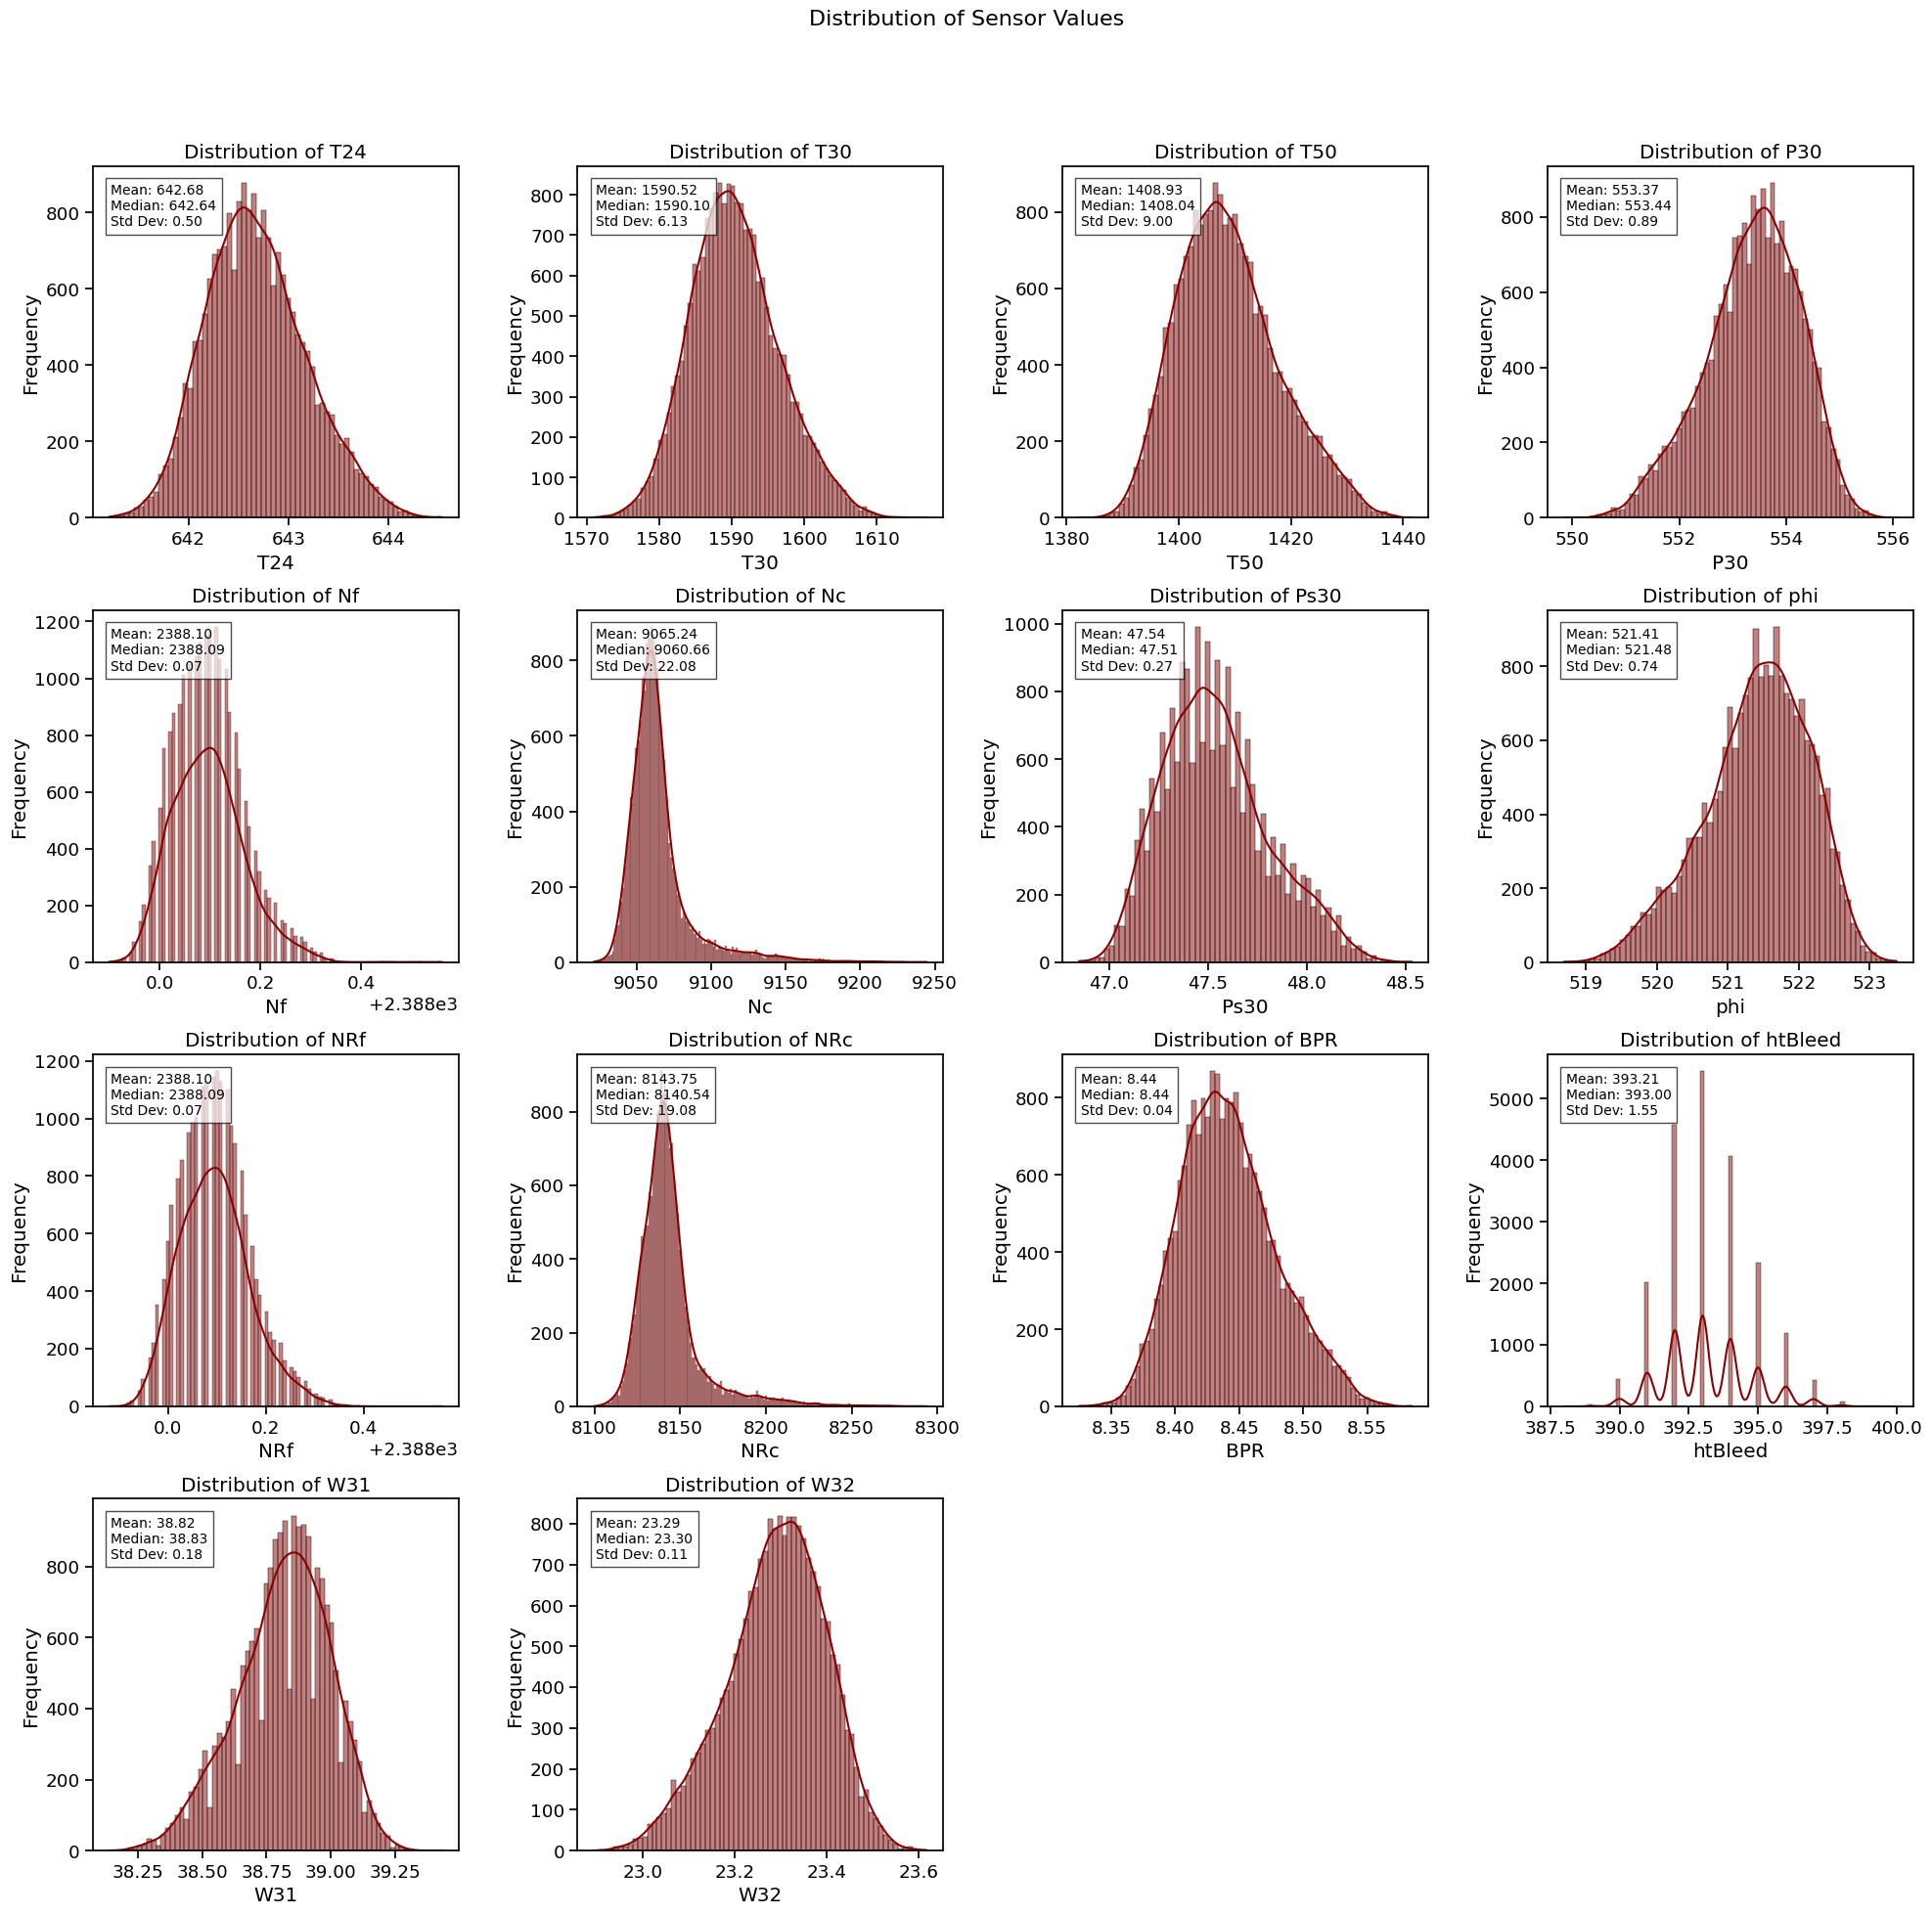

In [18]:
def displot_indicators(dataframe, title, indicators):
    """
    Create histograms showing the distribution of each sensor's values.

    Parameters:
    -----------
    dataframe : pandas.DataFrame
        DataFrame containing engine data
    title : str
        Title for the plot
    indicators : list
        List of sensor names to plot
    """
    # Count of indicators
    indicators_count = len(indicators)

    # Calculate grid dimensions - use 4 columns
    ncols = 4
    nrows = (indicators_count + ncols - 1) // ncols  # Ceiling division

    # Create subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))

    # Create and adjust title
    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(top=0.95)

    # Flatten axes for easier indexing
    axes = axes.flatten()

    # Iterate over indicators
    for i, indicator in enumerate(indicators):
        # Plot histogram
        sns.histplot(
            data=dataframe,
            ax=axes[i],
            x=indicator,
            kde=True,  # Add density curve
            color='darkred'
        )

        # Add descriptive labels
        axes[i].set_title(f"Distribution of {indicator}")
        axes[i].set_xlabel(indicator)
        axes[i].set_ylabel("Frequency")

        # Calculate basic statistics
        mean_val = dataframe[indicator].mean()
        median_val = dataframe[indicator].median()
        std_val = dataframe[indicator].std()

        # Add statistics annotation
        axes[i].text(
            0.05, 0.95,
            f"Mean: {mean_val:.2f}\nMedian: {median_val:.2f}\nStd Dev: {std_val:.2f}",
            transform=axes[i].transAxes,
            fontsize=10,
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.7)
        )

    # Delete remaining empty axes
    for j in range(indicators_count, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout and show plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig('sensor_distributions.png')
    plt.show()

# Plot distributions for the key sensors
displot_indicators(
    train_data_with_rul,
    'Distribution of Sensor Values',
    key_degradation_sensors
)

🔑 Key Insights:
- Most sensors show normal or skewed distributions
- Sensors with multi-modal distributions may indicate different operating conditions
- Wide distributions suggest high variability across engines or operating conditions
- Narrow distributions indicate consistent sensor behavior

💡 Real-world Translation:
- These distributions are like benchmarks - showing what "normal" looks like across many engines
- Unusual values outside the typical range can be early warning signs
- Understanding these distributions helps set appropriate alarm thresholds for monitoring systems

### SECTION 8: CORRELATION ANALYSIS
Let's analyze the relationships between different sensors and their correlation with RUL.
This helps identify which sensors provide redundant information and which are most
predictive of engine failure.

In [19]:
print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)
print("\n📊 Correlation Between Sensors and RUL")
print("These heatmaps show how sensors relate to each other and to remaining useful life.")


CORRELATION ANALYSIS

📊 Correlation Between Sensors and RUL
These heatmaps show how sensors relate to each other and to remaining useful life.


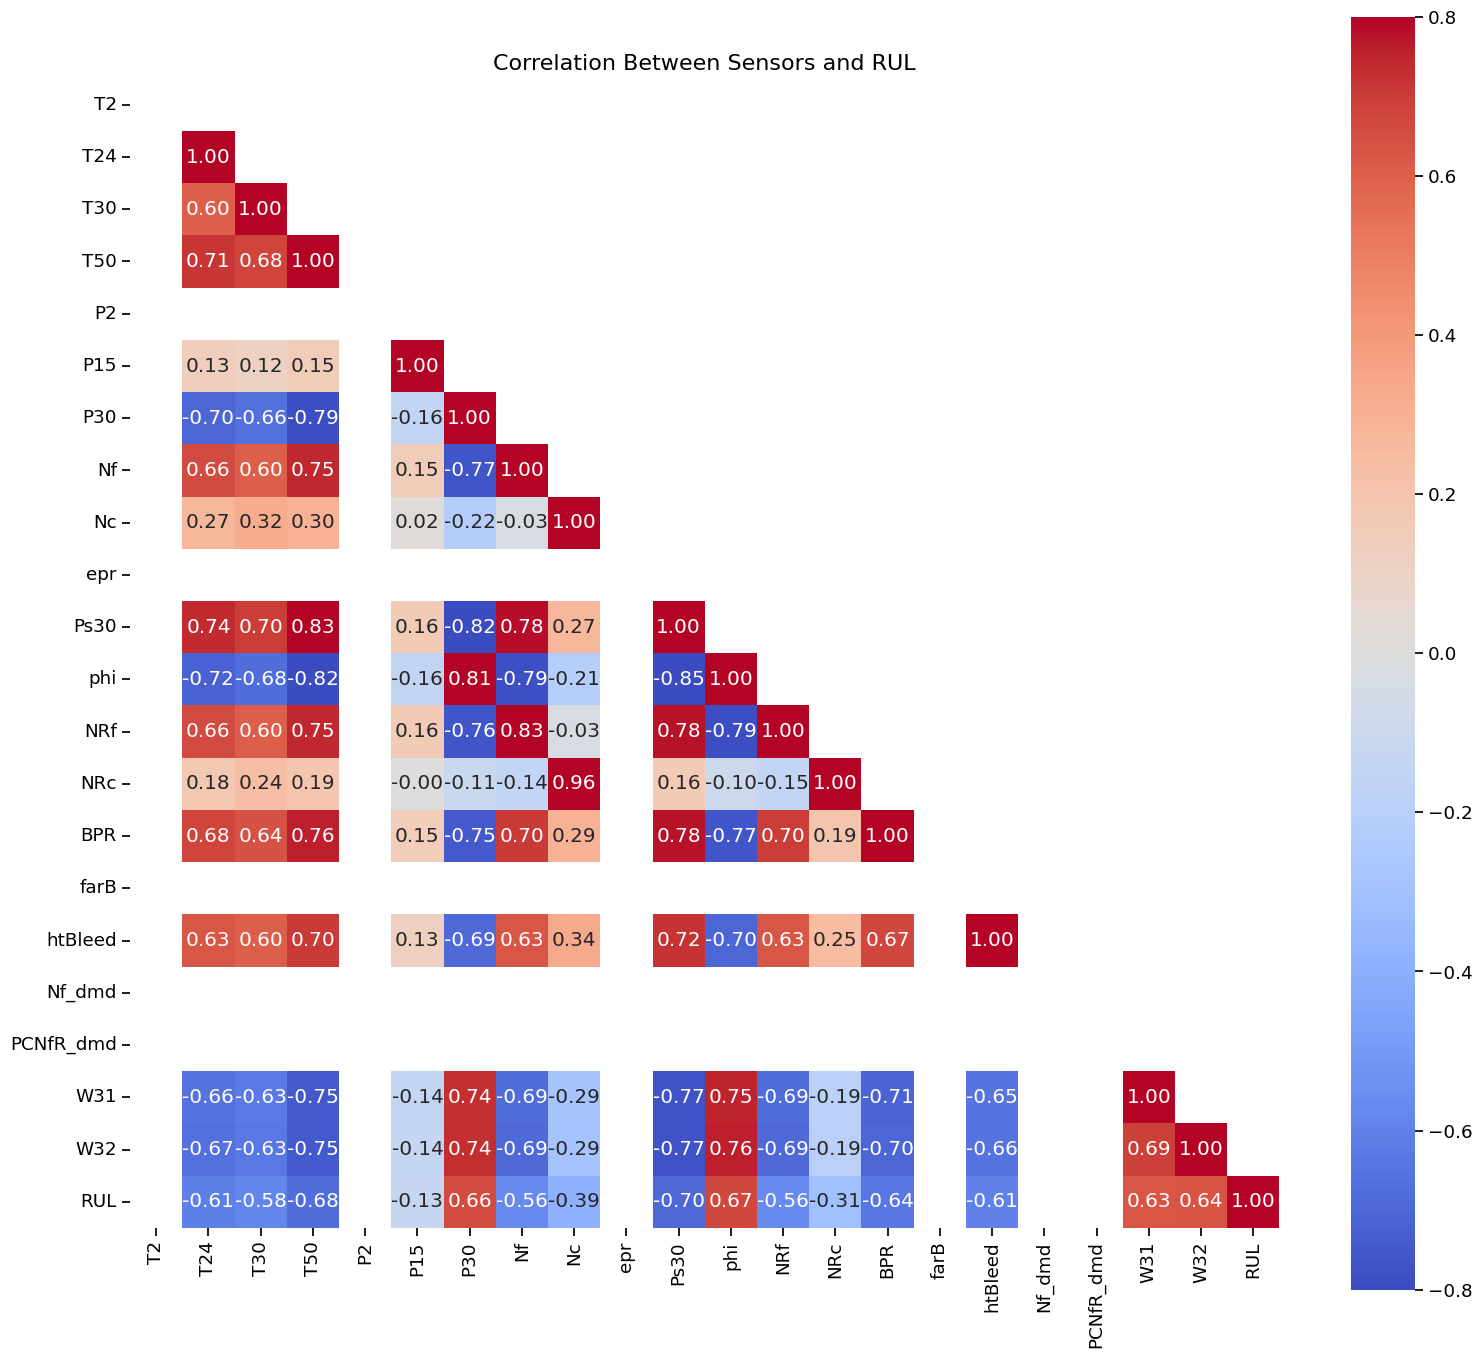


🔍 Strong Correlations Identified:
  • T50 has a moderate to strong positive correlation with T24 (r = 0.71)
  • P30 has a moderate to strong negative correlation with T24 (r = -0.70)
  • P30 has a moderate to strong negative correlation with T50 (r = -0.79)
  • Nf has a moderate to strong positive correlation with T50 (r = 0.75)
  • Nf has a moderate to strong negative correlation with P30 (r = -0.77)
  • Ps30 has a moderate to strong positive correlation with T24 (r = 0.74)
  • Ps30 has a strong positive correlation with T50 (r = 0.83)
  • Ps30 has a strong negative correlation with P30 (r = -0.82)
  • Ps30 has a moderate to strong positive correlation with Nf (r = 0.78)
  • phi has a moderate to strong negative correlation with T24 (r = -0.72)
  • phi has a strong negative correlation with T50 (r = -0.82)
  • phi has a strong positive correlation with P30 (r = 0.81)
  • phi has a moderate to strong negative correlation with Nf (r = -0.79)
  • phi has a strong negative correlation wi

In [20]:
def correlation_heatmap(dataframe, indicators):
    """
    Create a correlation heatmap between sensors and RUL.

    Parameters:
    -----------
    dataframe : pandas.DataFrame
        DataFrame containing engine data with RUL
    indicators : list
        List of sensor names to analyze
    """
    # Add RUL to the indicators list for correlation analysis
    indicators_with_rul = indicators + ['RUL']

    # Compute correlation matrix
    correlation_matrix = dataframe[indicators_with_rul].corr()

    # Create mask to show only lower half of heatmap (avoid redundancy)
    mask = np.zeros_like(correlation_matrix)
    mask[np.triu_indices_from(mask, k=1)] = True

    # Create heatmap
    plt.figure(figsize=(16, 14))
    sns.heatmap(
        data=correlation_matrix,
        mask=mask,
        vmax=0.8,
        vmin=-0.8,
        center=0,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        square=True
    )

    plt.title("Correlation Between Sensors and RUL", fontsize=16)
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png')
    plt.show()

    # Print textual analysis of strong correlations
    print("\n🔍 Strong Correlations Identified:")

    # Iterate over correlation matrix columns
    for i, ind1 in enumerate(indicators_with_rul):
        # Iterate over elements from lower triangle in the heatmap
        for j in range(i):
            ind2 = indicators_with_rul[j]
            corr_value = correlation_matrix.iloc[i, j]

            # Print interpretation for strong correlations
            if abs(corr_value) > 0.7:
                correlation_type = "positive" if corr_value > 0 else "negative"
                strength = "strong" if abs(corr_value) > 0.8 else "moderate to strong"

                print(f"  • {ind1} has a {strength} {correlation_type} correlation with {ind2} (r = {corr_value:.2f})")

                # If correlation is with RUL, provide additional explanation
                if ind1 == 'RUL' or ind2 == 'RUL':
                    other_variable = ind2 if ind1 == 'RUL' else ind1
                    if corr_value > 0:
                        print(f"    → As {other_variable} increases, RUL tends to increase (sensor reading improves as engine health improves)")
                    else:
                        print(f"    → As {other_variable} increases, RUL tends to decrease (sensor reading worsens as engine degrades)")

# Create correlation heatmap for sensors and RUL
correlation_heatmap(train_data_with_rul, sensors)

# Create a more targeted correlation visualization specifically for RUL
print("\n📊 Sensors Most Correlated with RUL")
print("These are the sensors most predictive of remaining useful life.")


<ipython-input-21-7e71733cbdbc>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=correlations.index, y=correlations.values, palette=colors)


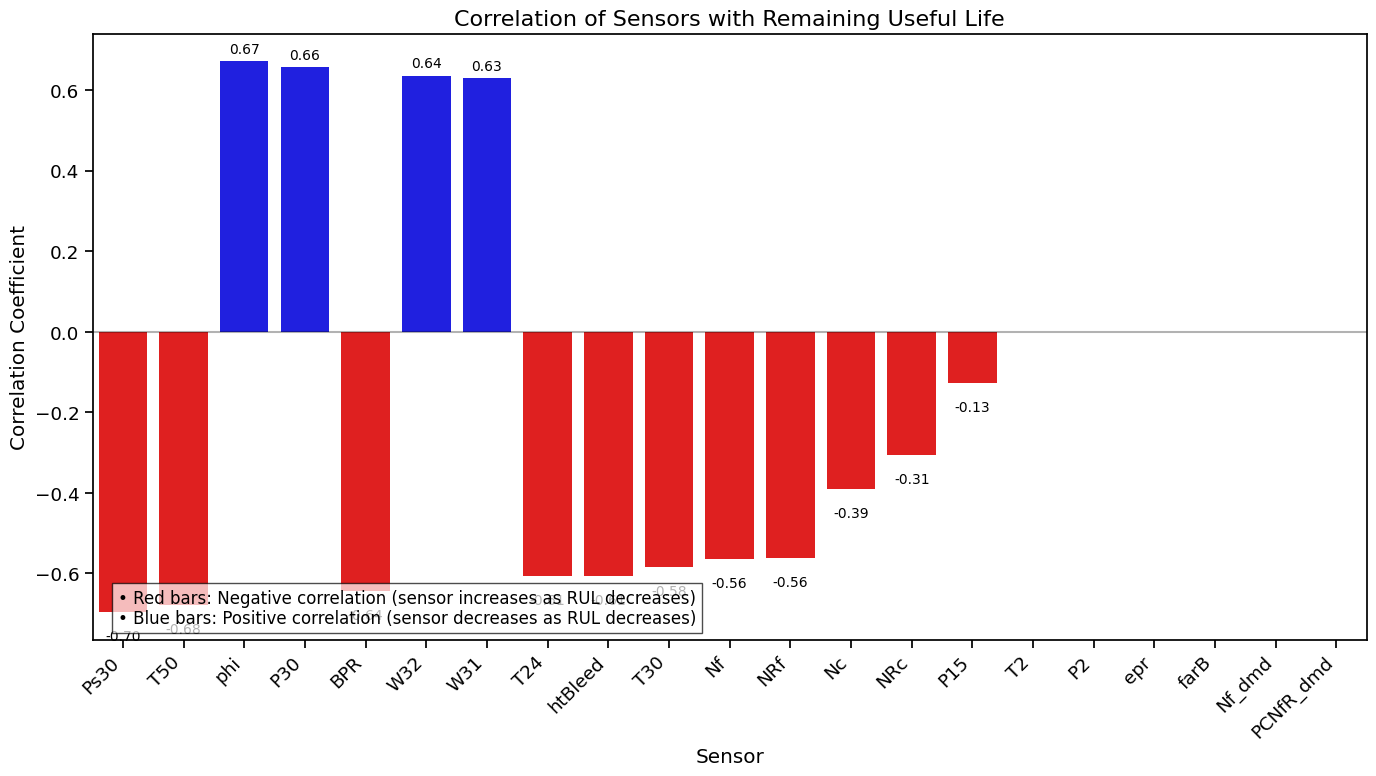

In [21]:
def plot_rul_correlations(dataframe, indicators):
    """
    Create a bar chart showing correlation of each sensor with RUL.

    Parameters:
    -----------
    dataframe : pandas.DataFrame
        DataFrame containing engine data with RUL
    indicators : list
        List of sensor names to analyze
    """
    # Calculate correlation with RUL
    correlations = dataframe[indicators + ['RUL']].corr()['RUL'].drop('RUL')

    # Sort by absolute correlation value
    correlations = correlations.reindex(correlations.abs().sort_values(ascending=False).index)

    # Create color mapping (red for negative, blue for positive)
    colors = ['red' if c < 0 else 'blue' for c in correlations]

    # Create bar chart
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x=correlations.index, y=correlations.values, palette=colors)

    # Add labels
    plt.title("Correlation of Sensors with Remaining Useful Life", fontsize=16)
    plt.xlabel("Sensor")
    plt.ylabel("Correlation Coefficient")
    plt.xticks(rotation=45, ha='right')

    # Add correlation values
    for i, v in enumerate(correlations.values):
        ax.text(i, v + 0.02 if v >= 0 else v - 0.07, f"{v:.2f}", ha='center', fontsize=10)

    # Add a horizontal line at zero
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

    # Add interpretation guidelines
    plt.text(
        0.02, 0.02,
        "• Red bars: Negative correlation (sensor increases as RUL decreases)\n• Blue bars: Positive correlation (sensor decreases as RUL decreases)",
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='bottom',
        bbox=dict(facecolor='white', alpha=0.7)
    )

    plt.tight_layout()
    plt.savefig('rul_correlations.png')
    plt.show()

# Plot correlations with RUL
plot_rul_correlations(train_data_with_rul, sensors)

🔑 Key Insights:
- Sensors with strong correlation to RUL are the most useful for predictive maintenance
- Highly correlated sensors provide redundant information and can be reduced for model efficiency
- The correlation sign indicates whether the sensor value increases or decreases as the engine degrades

💡 Real-world Translation:
- Think of these correlations like medical tests - some metrics are more reliable at predicting health issues than others
- Just as a doctor focuses on the most predictive tests, maintenance algorithms can focus on the most informative sensors
- Sensors with opposite correlations provide complementary information, potentially increasing prediction accuracy

### SECTION 9: SENSOR VARIABILITY ANALYSIS
Let's analyze the variability of each sensor to understand which ones show
the most significant changes that could be useful for prediction.

In [22]:
print("\n" + "="*80)
print("SENSOR VARIABILITY ANALYSIS")
print("="*80)
print("\n📊 Standard Deviation of Each Sensor")
print("This shows which sensors have the most variability across all engine data.")


SENSOR VARIABILITY ANALYSIS

📊 Standard Deviation of Each Sensor
This shows which sensors have the most variability across all engine data.


<ipython-input-23-2154a8cd8527>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=stats.index, y="std", data=stats, palette='magma')


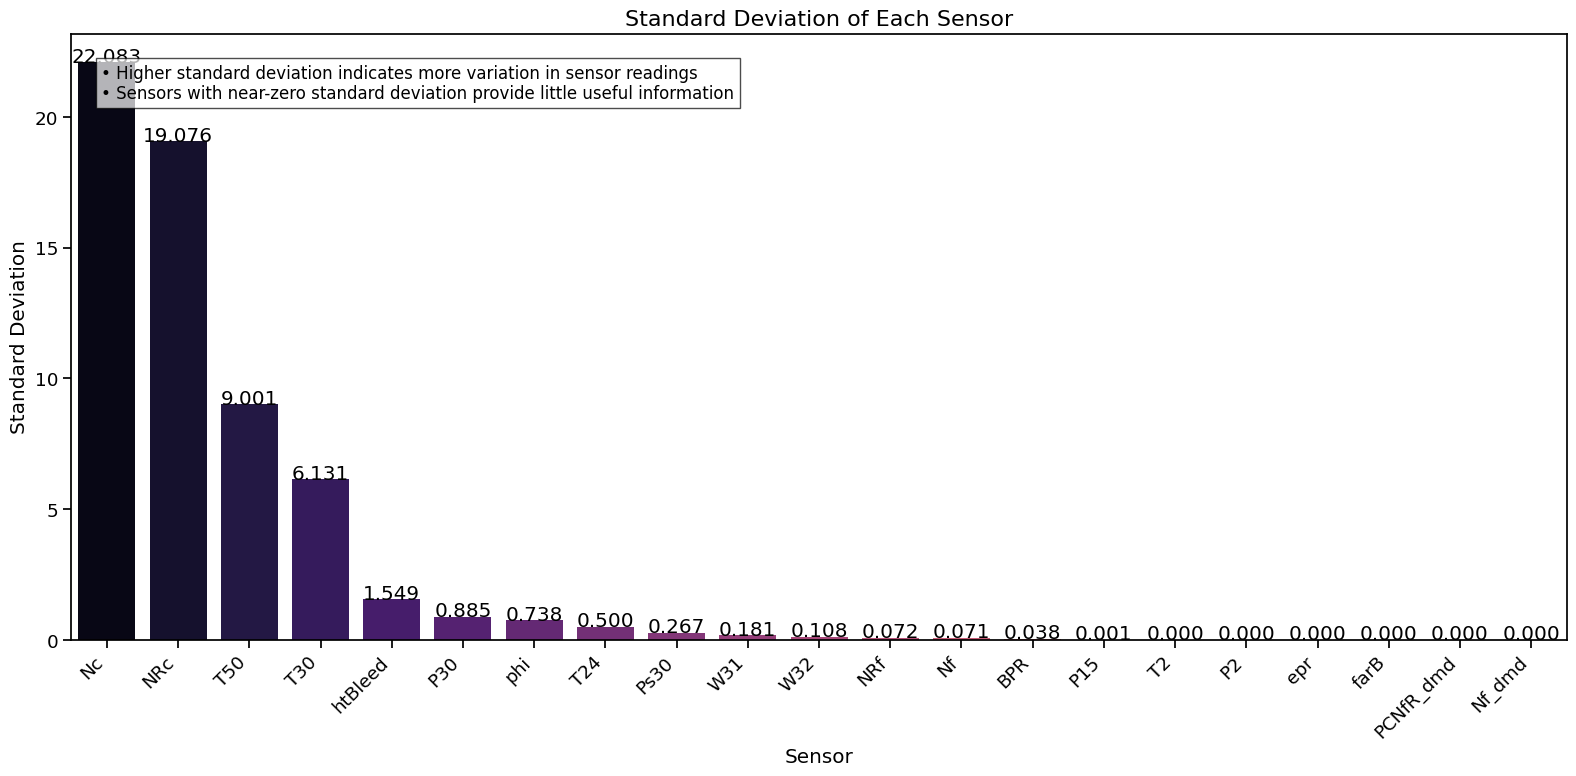

In [23]:
def plot_std_deviation(dataframe, sensors_list):
    """
    Create a bar chart showing the standard deviation of each sensor.

    Parameters:
    -----------
    dataframe : pandas.DataFrame
        DataFrame containing engine data
    sensors_list : list
        List of sensor names to analyze
    """
    # Calculate statistics for each sensor
    stats = dataframe[sensors_list].agg(['mean', 'std']).T

    # Sort by standard deviation
    stats = stats.sort_values('std', ascending=False)

    # Create bar chart
    plt.figure(figsize=(16, 8))
    ax = sns.barplot(x=stats.index, y="std", data=stats, palette='magma')

    # Add labels
    plt.title("Standard Deviation of Each Sensor", fontsize=16)
    plt.xlabel("Sensor")
    plt.ylabel("Standard Deviation")
    plt.xticks(rotation=45, ha='right')

    # Add standard deviation values
    for i, p in enumerate(ax.patches):
        ax.annotate(
            f"{p.get_height():.3f}",
            (p.get_x() + p.get_width() / 2., p.get_height() + 0.01),
            ha='center'
        )

    # Add interpretation
    plt.text(
        0.02, 0.95,
        "• Higher standard deviation indicates more variation in sensor readings\n• Sensors with near-zero standard deviation provide little useful information",
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.7)
    )

    plt.tight_layout()
    plt.savefig('sensor_variability.png')
    plt.show()

# Plot sensor variability
plot_std_deviation(train_data_with_rul, sensors)

🔑 Key Insights:
- Sensors with higher standard deviation show more variation across engine operations
- Near-zero standard deviation may indicate constant readings or measurement issues
- Higher variability doesn't necessarily mean better predictive power - correlation with RUL matters more
- Sensors with both high variability and strong correlation with RUL are ideal predictors

💡 Real-world Translation:
- This is like identifying which vital signs show meaningful changes during a health issue
- Sensors with little variation might be functioning correctly but may not be useful for prediction
- Maintenance algorithms can prioritize sensors that show significant changes as engines degrade

### SECTION 10: SUMMARY AND CONCLUSIONS
Let's summarize our findings and draw conclusions that can guide predictive maintenance strategies.

📋 Key Findings from Exploratory Data Analysis:

1. Operational Patterns:
   • Engines operated under consistent conditions, making comparisons valid
   • Operational settings show little variation, suggesting controlled test conditions

2. Degradation Indicators:
   • Several sensors show clear degradation patterns as engines approach failure
   • The most informative sensors for RUL prediction include:
     - T24, T30 and T50 (temperature sensors)
     - P30 and Ps30 (pressure sensors)
     - NRf and NRc (corrected speed measurements)

3. Correlation Insights:
   • Strong correlations exist between several sensor pairs, indicating redundant information
   • Several sensors show strong correlation with RUL, making them valuable for prediction
   • Some sensors show little correlation with RUL and can be excluded from models

4. Variability Analysis:
   • Sensors vary in their standard deviation, with some showing much more variability than others
   • Combining variability with correlation helps identify the most useful predictors

💡 Business Implications:

1. Predictive Maintenance Opportunities:
   • Clear degradation patterns enable predictive maintenance systems
   • Multiple correlated sensors provide redundancy for reliable predictions
   • Models can focus on the most informative sensors to improve efficiency

2. Operational Efficiency:
   • Early detection of potential failures allows for planned maintenance
   • Reducing unexpected failures decreases downtime and maintenance costs
   • Data-driven maintenance schedules can optimize engine lifespans

3. Safety Enhancements:
   • Monitoring key degradation indicators improves flight safety
   • Multiple independent sensors provide redundant warning systems
   • Trend analysis allows for safety margin optimization

4. Cost Reduction Potential:
   • Planned vs. emergency maintenance reduces costs
   • Extended engine life through optimal maintenance timing
   • Reduced inventory needs through better failure prediction

🚀 Next Steps:

1. Feature Selection:
   • Use correlation and variability analysis to select optimal sensor features
   • Consider dimensionality reduction to handle correlated sensors

2. Model Development:
   • Build predictive models using selected features to estimate RUL
   • Evaluate regression and classification approaches for different use cases

3. Threshold Determination:
   • Establish warning thresholds for key sensors based on RUL correlation
   • Develop multi-sensor decision rules for maintenance alerts

4. Validation Strategy:
   • Validate predictions using the test dataset
   • Measure prediction accuracy at different failure horizons (e.g., 30, 20, 10 cycles before failure)